In [1]:
import chess
import json
import numpy as np
import io
import time
# import tensorflow as tf
from chess.pgn import read_game
import collections
from types import SimpleNamespace
from chess_engine.zima_common import engine
import matplotlib.pyplot as plt
%matplotlib inline

### Making the Policy

There are many ways to make the policy, one of the simplest methods is to have 2 heads, one to tell `from square` and the other to tell `to square`. But we are more interested in the method that was used in AlphaZero paper. Following is the content from the paper:

``` text
A move in chess may be described in two parts: selecting the piece to move, and then selecting among the legal moves for that piece. We represent the policy π(a|s) by a 8 × 8 × 73 stack of planes encoding a probability distribution over 4,672 possible moves. Each of the 8×8 positions identifies the square from which to “pick up” a piece. The first 56 planes encode possible ‘queen moves’ for any piece: a number of squares [1..7] in which the piece will be moved, along one of eight relative compass directions {N, NE, E, SE, S, SW, W, NW}. The next 8 planes encode possible knight moves for that piece. The final 9 planes encode possible underpromotions for pawn moves or captures in two possible diagonals, to knight, bishop or rook respectively. Other pawn moves or captures from the seventh rank are promoted to a queen.
```

This can be explained in the following manner.

If a Queen is placed at the corner of the board there are 21 possible moves for that Queen. If the queen is placed in any of the centre 4 boxes then it has 27 possible moves (screenshots given below):

<img src="./explain/qcorner.png">
<img src="./explain/qcentre.png">
<img src="./explain/qcorner2.png">

But in order to make a 100% generalised policy we need to have a policy that can operate on each tile in every direction. And we have 8 possible directions {N, NE, E, SE, S, SW, W, NW} So for each tile we can have 56 possible directions of movement (**NOTE: most of these will be illegal, pass through object, put piece off board, etc. these are masked later on.**). These are "Queen moves"(56), including the "Knight moves" for each position (8) and other moves (9) which make up the sum 73 (`56 + 8 + 9 = 73`).

Thus giving us the action space of `8x8x73` and so when we perform the softmax we do not perform it over each `8x8x1` but instead over each tile i.e. `1x1x73`. Son of a bitch this is clever, it took me 2 hours to actually understand what the fuck is actually happening here!

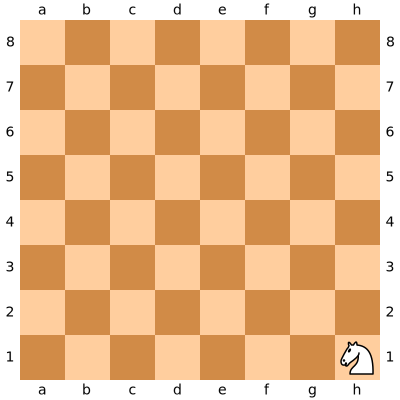

In [25]:
board = chess.Board('8/8/8/8/8/8/8/7N')
board

In [30]:
for move in board.legal_moves:
    print(move, move.from_square, move.to_square)

h1g3 7 22
h1f2 7 13


In [36]:
board.fen()

'8/8/8/8/8/8/8/7N w - - 0 1'

In [5]:
import tensorflow as tf
from chess_engine.zima_common import common_layers

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [43]:
def value_network_alphazero(iter_obj, config, lr = 0.2):
    """
    This is only the value head part for this network and not the policy head
    piece, so I think we may get away with using less number of layers. The
    alpha zero network is defined as (p,v) = f_theta(s) whereas this only
    value network is defined as v = f_theta(s) where theta are the parameters

    As far as the training is concerned the learning rate was dropped twice
    during the training. It starts with 0.2, then is dropped to 0.02 at 100k,
    then to 0.002 at 300k and 0.0002 at 500k.
    """
    board = tf.cast(iter_obj.board, tf.float32)
    batch_size = common_layers.shapes_list(board)[0]
    # defined is the regularisation loss
    with tf.variable_scope("zima_alphazero_value", regularizer = tf.keras.regularizers.l2()):
        out = tf.layers.batch_normalization(
            tf.layers.conv2d(board, 256, 3, padding = 'same'),
            training=config.training)
        for layer_idx in range(19):
#             print(layer_idx)
            with tf.variable_scope("stack_{}".format(layer_idx)):
                conv_out = tf.nn.relu(tf.layers.batch_normalization(
                    tf.layers.conv2d(out, 256, 3, padding = 'same'), training=config.training))
#                 print(conv_out)
                conv_out = tf.nn.relu(tf.layers.batch_normalization(
                    tf.layers.conv2d(conv_out, 256, 3, padding = 'same'), training=config.training))
#                 print(conv_out)
                out += conv_out

        out = tf.nn.relu(tf.layers.batch_normalization(
            tf.layers.conv2d(out, 1, 1, padding = 'same'), training=config.training))
        out = tf.reshape(out, [batch_size, 64], name = 'flatten')
        out = tf.nn.relu(tf.layers.dense(out, 265))
        value_out = tf.nn.tanh(tf.layers.dense(out, 1))
        print(value_out)

    if config.training:
        # we need to define the loss function here
        """
        loss function is defined as follows:
        l = (z-v)^2 + c||theta||^2

        where ||x|| is L2 normalisation of x
        """
        value_target = tf.expand_dims(
            tf.cast(iter_obj.value_target, tf.float32),
            axis=1)
        value_loss = tf.reduce_sum(tf.math.squared_difference(value_out, value_target))
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        total_loss = value_loss + config.reg_const * sum(reg_losses)

In [44]:
tf.reset_default_graph()
in_ = SimpleNamespace(
    board = tf.placeholder(tf.uint8, [None, 8, 8, 25]),
    value_target = tf.placeholder(tf.int32, [None,])
)
config = SimpleNamespace(
    training = True,
    reg_const = 0.002
)
value_network_alphazero(in_, config)

Tensor("zima_alphazero_value/Tanh:0", shape=(?, 1), dtype=float32)
[<tf.Tensor 'zima_alphazero_value/conv2d/kernel/Regularizer/add:0' shape=() dtype=float32>, <tf.Tensor 'zima_alphazero_value/conv2d/bias/Regularizer/add:0' shape=() dtype=float32>, <tf.Tensor 'zima_alphazero_value/batch_normalization/gamma/Regularizer/add:0' shape=() dtype=float32>, <tf.Tensor 'zima_alphazero_value/batch_normalization/beta/Regularizer/add:0' shape=() dtype=float32>, <tf.Tensor 'zima_alphazero_value/batch_normalization/moving_mean/Regularizer/add:0' shape=() dtype=float32>, <tf.Tensor 'zima_alphazero_value/batch_normalization/moving_variance/Regularizer/add:0' shape=() dtype=float32>, <tf.Tensor 'zima_alphazero_value/stack_0/conv2d/kernel/Regularizer/add:0' shape=() dtype=float32>, <tf.Tensor 'zima_alphazero_value/stack_0/conv2d/bias/Regularizer/add:0' shape=() dtype=float32>, <tf.Tensor 'zima_alphazero_value/stack_0/batch_normalization/gamma/Regularizer/add:0' shape=() dtype=float32>, <tf.Tensor 'zima_a

Tensor("add_488:0", shape=(), dtype=float32)


In [45]:
tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

[<tf.Tensor 'zima_alphazero_value/conv2d/kernel/Regularizer/add:0' shape=() dtype=float32>,
 <tf.Tensor 'zima_alphazero_value/conv2d/bias/Regularizer/add:0' shape=() dtype=float32>,
 <tf.Tensor 'zima_alphazero_value/batch_normalization/gamma/Regularizer/add:0' shape=() dtype=float32>,
 <tf.Tensor 'zima_alphazero_value/batch_normalization/beta/Regularizer/add:0' shape=() dtype=float32>,
 <tf.Tensor 'zima_alphazero_value/batch_normalization/moving_mean/Regularizer/add:0' shape=() dtype=float32>,
 <tf.Tensor 'zima_alphazero_value/batch_normalization/moving_variance/Regularizer/add:0' shape=() dtype=float32>,
 <tf.Tensor 'zima_alphazero_value/stack_0/conv2d/kernel/Regularizer/add:0' shape=() dtype=float32>,
 <tf.Tensor 'zima_alphazero_value/stack_0/conv2d/bias/Regularizer/add:0' shape=() dtype=float32>,
 <tf.Tensor 'zima_alphazero_value/stack_0/batch_normalization/gamma/Regularizer/add:0' shape=() dtype=float32>,
 <tf.Tensor 'zima_alphazero_value/stack_0/batch_normalization/beta/Regularize

In [13]:
def get_lr_strategy(lr_init, lr_drops, global_step):
    lrs = [lr_init/10**(drop + 1) for drop in range(len(lr_drops))]
    lr = tf.constant(lr_init)
    for lr_updated, lr_step in zip(lrs, lr_drops):
        lr = tf.cond(global_step > lr_step, lambda: tf.constant(lr_updated), lambda: lr)
    return lr

In [17]:
tf.reset_default_graph()

lr_init = 0.2
lr_drops = [100,300,500]
global_step = tf.train.get_or_create_global_step()

# lrs = [lr_init/10**(drop + 1) for drop in range(len(lr_drops))]
# print(lrs)
# print(list(zip(lr_drops[::-1], lrs[::-1])))
# cases = []
# for lr, lr_step in zip(lrs[::-1], lr_drops[::-1]):
#     print(lr, lr_step)
#     cases.append(tf.greater_equal(global_step, lr_))

print(global_step)
lr = get_lr_strategy(lr_init, lr_drops, global_step)
# lr = noam_scheme(0.2, global_step, 300)
print(lr)

def simple_net(x, y, lr, gs):
    x = tf.matmul(x, tf.get_variable("weights", shape = [3, 4]))
    train_step = tf.train.GradientDescentOptimizer(lr).minimize(y - x, gs)
    return train_step

x = tf.placeholder(tf.float32, [None, 3])
y = tf.placeholder(tf.float32, [None, 4])
train_step = simple_net(x, y, lr, global_step)

<tf.Variable 'global_step:0' shape=() dtype=int64_ref>
[0.02, 0.002, 0.0002]
----- Tensor("cond/Merge:0", shape=(), dtype=float32) 0.02 100
----- Tensor("cond_1/Merge:0", shape=(), dtype=float32) 0.002 300
----- Tensor("cond_2/Merge:0", shape=(), dtype=float32) 0.0002 500
Tensor("cond_2/Merge:0", shape=(), dtype=float32)


In [18]:
lr_values = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        _lr, _, _gs = sess.run([lr, train_step , global_step],
                               {x: np.random.uniform(size = [4, 3]),
                                y: np.random.uniform(size = [4, 4])})
        lr_values.append(_lr)


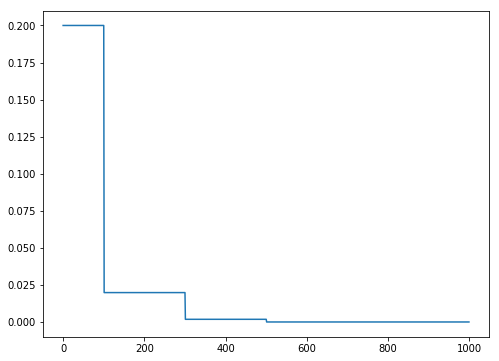

In [19]:
plt.figure(figsize = (8, 6))
plt.plot(lr_values)

In [80]:
x = 12
y = 15
z = 18

def f1(): return tf.constant(17)
def f2(): return tf.constant(23)
def f3(): return tf.constant(-1)
r = tf.case([(tf.less(x, y), f1), (tf.greater(x, z), f2)],
         default=f3, exclusive=True)
print(r)

Tensor("case/cond/Merge:0", shape=(), dtype=int32)


In [59]:
def noam_scheme(init_lr, global_step, warmup_steps=4000.):
    step = tf.cast(global_step + 1, dtype=tf.float32)
    return init_lr * warmup_steps ** 0.5 * tf.minimum(step * warmup_steps ** -1.5, step ** -0.5)

In [60]:
noam_scheme(0.2, 0)

<tf.Tensor 'mul_2:0' shape=() dtype=float32>

In [8]:
def load_data(fpath):
    start_time = time.time()
    game_strings = []
    print(f'<><><><><><><><><><><> fpath: {fpath}')
    all_lines = open(fpath, 'r', encoding='utf-8').readlines()
    this_game = ''
    for line_idx, line in enumerate(all_lines):
        this_game += line
        if line.split() and line.split()[-1] in ['0-1', '1-0', '1/2-1/2']:
            game_strings.append(str(this_game))
            this_game = ''
#     print(
#         f'-------------------- it took {time.time() - start_time}s to load the completely load the dataset')
#     print(f'--------------- Number of Samples: {len(game_strings)}')
#     print(f'--------------  return object type: {type(game_strings)}')
    return list(game_strings)

game_strings = load_data('KB_small.pgn')

<><><><><><><><><><><> fpath: KB_small.pgn


In [52]:
RESULT_VALUE = {'0-1': -1, '1/2-1/2':0, '1-0': 1}

def generator_fn(file_paths, gram_size=3):
    print(gram_size)
    games_buffer = collections.deque()
    for fpath in file_paths:
        for game_string in load_data(fpath):
            try:
                game = chess.pgn.read_game(
                    io.StringIO(game_string.decode('utf-8')))
            except:
                game = chess.pgn.read_game(io.StringIO(game_string))
            board = game.board()
            game_result = RESULT_VALUE[game.headers['Result']]
            player_old = 1
            print('ININTINTITNITNITNTITN', board.fen())
            print('----->', board.turn * 1, game_result)
            for midx, move in enumerate(game.mainline_moves()):
                print('\n-------------')
                print(board.fen())
                if midx == 0:
                    games_buffer.appendleft(board.fen())
                board.push(move)
                print(board.fen())
                games_buffer.appendleft(board.fen())
#                 print(len(games_buffer))
                game_result *= -1.
                if len(games_buffer) == gram_size:
                    print('11111111111')
                    games = list(games_buffer)
                    game_states = [engine.make_state(game, player_layer=True) for game in games]
                    target_state = game_states[0]
                    for game in game_states[1:]:
                        target_state = np.append(target_state, game, axis = -1)
#                     print('1,', target_state.shape)
                    yield target_state, game_result
                    games_buffer.pop()

                elif len(games_buffer) < gram_size:
                    print('22222222222')
                    # stack with zeros is the idea
                    games = list(games_buffer)
                    game_states = [engine.make_state(game, player_layer=True) for game in games]
                    target_state = game_states[0]
                    for game in game_states[1:]:
                        target_state = np.append(target_state, game, axis = -1)
                    for _ in range(gram_size - len(games_buffer)):
                        target_state = np.append(target_state, np.zeros(shape = (8, 8, 5)), axis = -1)
#                     print('2,', target_state.shape)
                    yield target_state, game_result


for gen_idx, gen in enumerate(generator_fn(['KB_small.pgn'], 4)):
    if 10 > gen_idx > 4:
        print('-------', gen_idx)
        print(gen[0].shape, gen[1])
        break

4
<><><><><><><><><><><> fpath: KB_small.pgn
ININTINTITNITNITNTITN rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
-----> 1 -1

-------------
rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
22222222222

-------------
rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1
rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 1 2
22222222222

-------------
rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 1 2
rnbqkb1r/pppppppp/5n2/6B1/3P4/8/PPP1PPPP/RN1QKBNR b KQkq - 2 2
11111111111

-------------
rnbqkb1r/pppppppp/5n2/6B1/3P4/8/PPP1PPPP/RN1QKBNR b KQkq - 2 2
rnbqkb1r/pp1ppppp/5n2/2p3B1/3P4/8/PPP1PPPP/RN1QKBNR w KQkq - 0 3
11111111111

-------------
rnbqkb1r/pp1ppppp/5n2/2p3B1/3P4/8/PPP1PPPP/RN1QKBNR w KQkq - 0 3
rnbqkb1r/pp1ppppp/5B2/2p5/3P4/8/PPP1PPPP/RN1QKBNR b KQkq - 0 3
11111111111

-------------
rnbqkb1r/pp1ppppp/5B2/2p5/3P4/8/PPP1PPPP/RN1QKBNR b KQkq - 0 3
rnbqkb1r/pp1ppp1p/5p2/2p5/3P4/8/PPP

In [20]:
x = np.random.uniform(size = (2,2,3))
for _ in range(4):
    x = np.append(x, np.zeros((2, 2, 3)), axis = -1)
    print(x.shape)
    print(x)

NameError: name 'np' is not defined

In [230]:
def load_data(fpath, ret_len = False):
    game_strings = []
    all_lines = open(fpath, 'r', encoding='utf-8').readlines()
    this_game = ''
    for line_idx, line in enumerate(all_lines):
        this_game += line
        if line.split() and line.split()[-1] in ['0-1', '1-0', '1/2-1/2']:
            game_strings.append(str(this_game))
            this_game = ''
    if ret_len:
        return len(game_strings)
    return list(game_strings)


def generator_fn(all_games, gram_size=3):
    for game_string in all_games:
        games_buffer = collections.deque()
        try:
            game = chess.pgn.read_game(
                io.StringIO(game_string.decode('utf-8')))
        except:
            game = chess.pgn.read_game(io.StringIO(game_string))
        board = game.board()
        game_result = engine.RESULT_VALUE[game.headers['Result']]
        print('----------> ', game_result, game.headers['Result'], game.headers)
        player_old = 1
        for midx, move in enumerate(game.mainline_moves()):
            if midx == 0:
                games_buffer.appendleft(board.fen())
            if len(games_buffer) == gram_size:
                # return game state as is
                games = list(games_buffer)
                game_states = [engine.make_state(
                    game, player_layer=True) for game in games]
                target_state = game_states[0]
                for game in game_states[1:]:
                    target_state = np.append(target_state, game, axis=-1)
                yield target_state, int(game_result)
                games_buffer.pop()

            elif len(games_buffer) < gram_size:
                # stack with zeros is the idea
                games = list(games_buffer)
                game_states = [engine.make_state(
                    game, player_layer=True) for game in games]
                target_state = game_states[0]
                for game in game_states[1:]:
                    target_state = np.append(target_state, game, axis=-1)
                for _ in range(gram_size - len(games_buffer)):
                    target_state = np.append(
                        target_state, np.zeros(shape=(8, 8, 5)), axis=-1)
                yield target_state, int(game_result)

            # once the current board is returned update the move
            board.push(move)
            games_buffer.appendleft(board.fen())
            game_result *= -1.

def input_fn(all_games, batch_size, gram_size, shuffle=False):
    '''Returns:
        tuple of (board [stack_size, 8x8X4], from_move, to_move, result)'''
    shapes = ([8, 8, 5 * gram_size], [])
    types = (tf.uint8, tf.int32)

    dataset = tf.data.Dataset.from_generator(
        generator_fn,
        output_shapes=shapes,
        output_types=types,
        args=(all_games,gram_size,)
    )

    dataset = dataset.repeat()  # iterate forever
    if shuffle:  # for training
        dataset.shuffle(128*batch_size)
    dataset = dataset.padded_batch(batch_size, shapes).prefetch(1)
    return dataset

def get_batches(file_paths, batch_size, gram_size, shuffle = False):
    tot_games = 0
    all_games = []
    for fpath in file_paths:
        tot_games += load_data(fpath, True)
        all_games.extend(load_data(fpath))
    approx_total_moves = tot_games * 50
    batches = input_fn(all_games, batch_size, gram_size, shuffle)
    return batches, approx_total_moves // batch_size + int(approx_total_moves % batch_size != 0), approx_total_moves

In [231]:
batches, num_batches, tot_games = get_batches(['KB_small.pgn'], 64, 4, True)
# batches = get_batches(['KB_small.pgn'], 64, 4, True)

In [232]:
iter = tf.data.Iterator.from_structure(
        batches.output_types, batches.output_shapes)
xs = iter.get_next()
train_init_op = iter.make_initializer(batches)

In [233]:
xs

(<tf.Tensor 'IteratorGetNext_28:0' shape=(?, 8, 8, 20) dtype=uint8>,
 <tf.Tensor 'IteratorGetNext_28:1' shape=(?,) dtype=int32>)

In [235]:
with tf.Session() as sess:
    sess.run(train_init_op)
    for _ in range(100):
        board, results = sess.run(xs)
#         print(board.shape)
        print(results)
#         print(board[4, 1:4, 0])

---------->  -1 0-1 Headers(Event='Karoun Masters Cup 2019', Site='Ahvaz IRI', Date='2019.02.25', Round='6.2', White='Abbasifar, Hasan', Black='Grigoryan, Karen H', Result='0-1', BlackElo='2590', ECO='A45', EventDate='2019.02.21', WhiteElo='2401')
[-1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1
 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1
 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1]
---------->  1 1-0 Headers(Event='Aeroflot Open A 2019', Site='Moscow RUS', Date='2019.02.25', Round='7.1', White='Martirosyan, Haik M', Black='Sasikiran, Krishnan', Result='1-0', BlackElo='2678', ECO='E66', EventDate='2019.02.20', WhiteElo='2616')
[-1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1  1 -1  1 -1
  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1
  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1]
---------->  1 1-0 Headers(Event='Aeroflot Open A 2019', Site='Moscow RUS', Date='2019.02.25', Round='7.49', Wh

KeyboardInterrupt: 

In [229]:
-0.0 * -1

0.0

In [213]:
def load_data(fpath, ret_len=False):
    game_strings = []
    this_game = ''
    for line_idx, line in enumerate(open(fpath, 'r', encoding='utf-8')):
        this_game += line
        if line.split() and line.split()[-1] in ['0-1', '1-0', '1/2-1/2']:
            game_strings.append(str(this_game))
            this_game = ''
    if ret_len:
        return len(game_strings)
    return list(game_strings)

def generator_fn(file_paths, gram_size=3):
    while True:
        for fpath in file_paths:
            for game_string in load_data(fpath):
                games_buffer = collections.deque()
                try:
                    game = chess.pgn.read_game(
                        io.StringIO(game_string.decode('utf-8')))
                except:
                    game = chess.pgn.read_game(io.StringIO(game_string))
                board = game.board()
                game_result = engine.RESULT_VALUE[game.headers['Result']]
#                 print('----------> ', game.headers, game_result, len(games_buffer))
                player_old = 1
                for midx, move in enumerate(game.mainline_moves()):
                    if midx == 0:
                        games_buffer.appendleft(board.fen())
                    if len(games_buffer) == gram_size:
                        # return game state as is
                        games = list(games_buffer)
                        game_states = [engine.make_state(
                            game, player_layer=True) for game in games]
                        target_state = game_states[0]
                        for game in game_states[1:]:
                            target_state = np.append(target_state, game, axis=-1)
                        yield target_state, float(game_result)
                        games_buffer.pop()

                    elif len(games_buffer) < gram_size:
                        # stack with zeros is the idea
                        games = list(games_buffer)
                        game_states = [engine.make_state(
                            game, player_layer=True) for game in games]
                        target_state = game_states[0]
                        for game in game_states[1:]:
                            target_state = np.append(target_state, game, axis=-1)
                        for _ in range(gram_size - len(games_buffer)):
                            target_state = np.append(
                                target_state, np.zeros(shape=(8, 8, 5)), axis=-1)
                        yield target_state, float(game_result)

                    # once the current board is returned update the move
                    board.push(move)
                    games_buffer.appendleft(board.fen())
                    game_result *= -1.
                
def shuffle_buffer(generator_fn, batch_size, buffer_mult = 128):
    buffer_memory = []
    for gen in generator_fn:
        buffer_memory.append(gen)
#         print('======', len(buffer_memory))
        if len(buffer_memory) > batch_size * buffer_mult:
            idx = np.random.randint(len(buffer_memory))
            yield buffer_memory[idx:idx+batch_size]
            del buffer_memory[idx:idx+batch_size]
            

def get_batches(file_paths, batch_size, gram_size, , shuffle=False):
    batch_state = []
    batch_result = []
    for gen in enumerate(shuffle_buffer(generator_fn(file_paths, gram_size), buffer_mult * batch_size)):
        batch_state.append(gen[0])
        batch_result.append(gen[1])
        if len(batch_state) == batch_size:
            yield batch_state, batch_result
                
for bidx, (batch_states, batch_results) in enumerate(get_batches(['KB_small.pgn'], 12, 4, 26)):
    print(len(batch_states), len(batch_results))
    if bidx > 4:
        break

-------> KB_small.pgn
12 12
-------> KB_small.pgn
-------> KB_small.pgn
-------> KB_small.pgn
-------> KB_small.pgn
-------> KB_small.pgn
-------> KB_small.pgn


KeyboardInterrupt: 

In [256]:
def load_data(fpath, ret_len=False):
    game_strings = []
    this_game = ''
    for line_idx, line in enumerate(open(fpath, 'r', encoding='utf-8')):
        this_game += line
        if line.split() and line.split()[-1] in ['0-1', '1-0', '1/2-1/2']:
            game_strings.append(str(this_game))
            this_game = ''
    if ret_len:
        return len(game_strings)
    return list(game_strings)

game = load_data("KB_small.pgn")

In [259]:
game1 = read_game(io.StringIO(game[0]))

In [275]:
print(game1.mainline_moves())
print(len([*game1.mainline_moves()]))

1. d4 Nf6 2. Bg5 c5 3. Bxf6 gxf6 4. d5 Qb6 5. Qc1 d6 6. g3 h5 7. h4 Bg4 8. Nd2 Nd7 9. c3 Ne5 10. Qc2 O-O-O 11. a4 a6 12. a5 Qc7 13. f4 Nd7 14. Nc4 e6 15. Bg2 f5 16. Ra3 e5 17. Nh3 Re8 18. O-O exf4 19. Nxf4 Bh6 20. e3 Ne5 21. Nb6+ Kb8 22. Qd2 Rhg8 23. Kh2 Be2 24. Nxe2 Ng4+ 25. Kh1 Rxe3 26. Qc2 Qe7 27. c4 Rxe2 28. Qxf5 Ne3 29. Qxf7 Qxf7 30. Rxf7 Rxg3 31. Bf1 Re1 32. Kh2 Rg8 33. Bh3 Bg7 34. Nd7+ Ka7 35. Rb3 Bd4 36. Rxb7+ Kxb7 37. Nb6+ Kb8 38. Nd7+ Kc8 39. Nf6+ Rg4 40. Rf8+ Kc7 41. Rf7+ Kd8 42. Nxg4 hxg4
84


In [272]:
print(game[0])

[Event "Karoun Masters Cup 2019"]
[Site "Ahvaz IRI"]
[Date "2019.02.25"]
[Round "6.2"]
[White "Abbasifar, Hasan"]
[Black "Grigoryan, Karen H"]
[Result "0-1"]
[WhiteElo "2401"]
[BlackElo "2590"]
[ECO "A45"]
[EventDate "2019.02.21"]

1.d4 Nf6 2.Bg5 c5 3.Bxf6 gxf6 4.d5 Qb6 5.Qc1 d6 6.g3 h5 7.h4 Bg4 8.Nd2 Nd7
9.c3 Ne5 10.Qc2 O-O-O 11.a4 a6 12.a5 Qc7 13.f4 Nd7 14.Nc4 e6 15.Bg2 f5 16.
Ra3 e5 17.Nh3 Re8 18.O-O exf4 19.Nxf4 Bh6 20.e3 Ne5 21.Nb6+ Kb8 22.Qd2 
Rhg8 23.Kh2 Be2 24.Nxe2 Ng4+ 25.Kh1 Rxe3 26.Qc2 Qe7 27.c4 Rxe2 28.Qxf5 Ne3
29.Qxf7 Qxf7 30.Rxf7 Rxg3 31.Bf1 Re1 32.Kh2 Rg8 33.Bh3 Bg7 34.Nd7+ Ka7 35.
Rb3 Bd4 36.Rxb7+ Kxb7 37.Nb6+ Kb8 38.Nd7+ Kc8 39.Nf6+ Rg4 40.Rf8+ Kc7 41.
Rf7+ Kd8 42.Nxg4 hxg4 0-1



In [ ]:
game